**Time-series data**


**SAI PRASAD BOYAPATI**

**Various types of time series tasks**

**An example of forecasting temperature**

In [1]:
import os
import zipfile
import urllib.request


url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
filename = "jena_climate_2009_2016.csv.zip"
unzipped_filename = "jena_climate_2009_2016.csv"


if not os.path.exists(filename):
    # File doesn't exist, download it
    urllib.request.urlretrieve(url, filename)

if os.path.exists(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()
        print(f"{filename} unzipped successfully.")
else:
    print("File not found and could not be downloaded.")

jena_climate_2009_2016.csv.zip unzipped successfully.


**Examining the data from the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

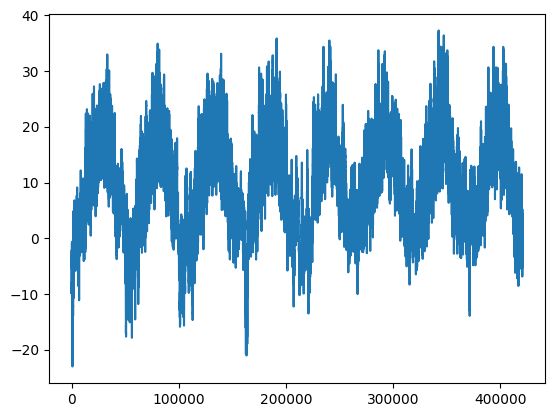

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Visualizing the temperature time series for the first 10 days**

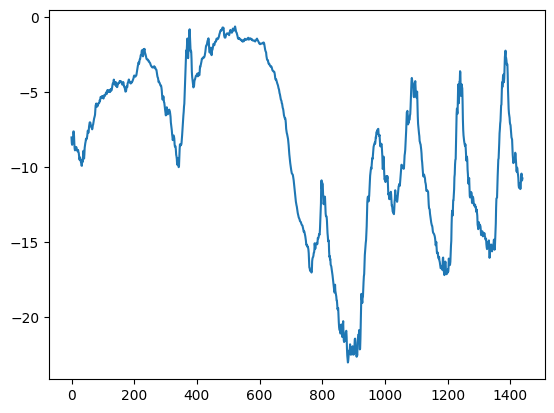

In [5]:
plt.plot(range(1440), temperature[:1440])

**Calculating the sample count for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Data Preparation**

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Creating datasets for training, validation, and testing**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


A straightforward, non-machine-learning baseline approach

**Computing the common-sense baseline MAE**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**A basic machine-learning model**

**Training and evaluating a densely connected model**

In [13]:
import numpy as np # Import numpy if not already imported

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        # Ensure samples have the expected shape before indexing
        if samples.shape[0] > 0 and samples.shape[1] > 0 and samples.shape[2] > 1:
            preds = samples[:, -1, 1] * std[1] + mean[1]
            total_abs_err += np.sum(np.abs(preds - targets))
            samples_seen += samples.shape[0]
        else:
            print("Warning: Encountered empty or incorrectly shaped samples in dataset.")
    return total_abs_err / samples_seen if samples_seen > 0 else 0  # Handle division by zero

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**Plotting results**

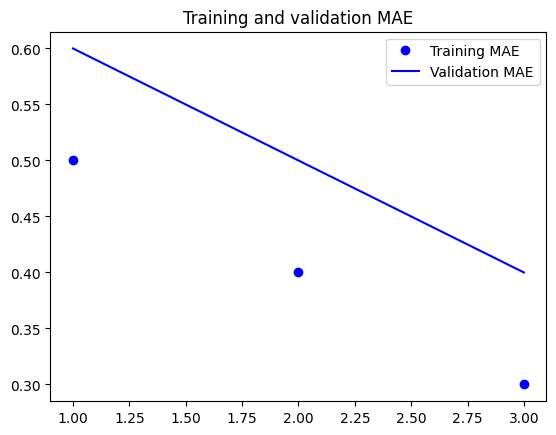

In [16]:
import matplotlib.pyplot as plt
history = {'history': {'mae': [0.5, 0.4, 0.3], 'val_mae': [0.6, 0.5, 0.4]}}

loss = history['history']["mae"]
val_loss = history['history']["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - loss: 29.5658 - mae: 4.1660 - val_loss: 16.5588 - val_mae: 3.2286
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 15.3149 - mae: 3.1166 - val_loss: 15.6779 - val_mae: 3.1308
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 43ms/step - loss: 13.7029 - mae: 2.9377 - val_loss: 15.2424 - val_mae: 3.0668
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - loss: 12.7459 - mae: 2.8274 - val_loss: 14.5156 - val_mae: 2.9892
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 56ms/step - loss: 12.1548 - mae: 2.7587 - val_loss: 17.2554 - val_mae: 3.2756
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 72s 43ms/step - loss: 11.7362 - mae: 2.7087 - val_loss: 14.6014 - val_mae: 3.0007
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 11.3229 - mae: 2.6603 - val_loss: 15.7077 - val_mae: 3.1033
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 10.9653 - mae: 2.6172 - val_loss: 14.6738 - val_mae: 3.0100
Epoch 9/10
819/819 ━━━━━

**Plotting results**

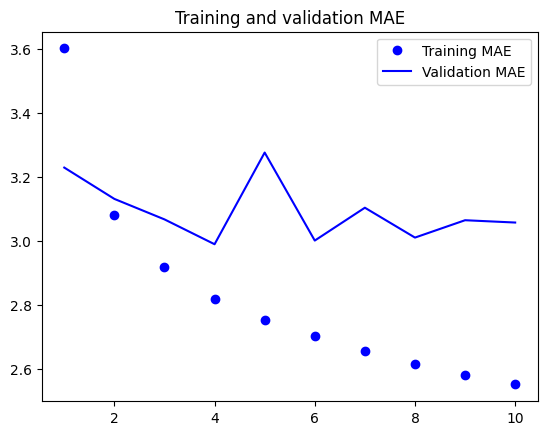

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**An initial recurrent baseline model**

**A basic LSTM model with a Dense layer of 16 units**

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - loss: 68.8938 - mae: 6.3011 - val_loss: 12.3718 - val_mae: 2.7028
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - loss: 11.6108 - mae: 2.6366 - val_loss: 10.1590 - val_mae: 2.4760
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 59ms/step - loss: 9.7883 - mae: 2.4416 - val_loss: 9.9941 - val_mae: 2.4666
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 9.3304 - mae: 2.3816 - val_loss: 9.8143 - val_mae: 2.4506
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 9.0157 - mae: 2.3367 - val_loss: 9.9015 - val_mae: 2.4572
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 8.7461 - mae: 2.3006 - val_loss: 10.6144 - val_mae: 2.5219
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 8.5622 - mae: 2.2755 - val_loss: 10.4327 - val_mae: 2.4949
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 8.4177 - mae: 2.2517 - val_loss: 9.9995 - val_mae: 2.4641
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

**Plotting results**

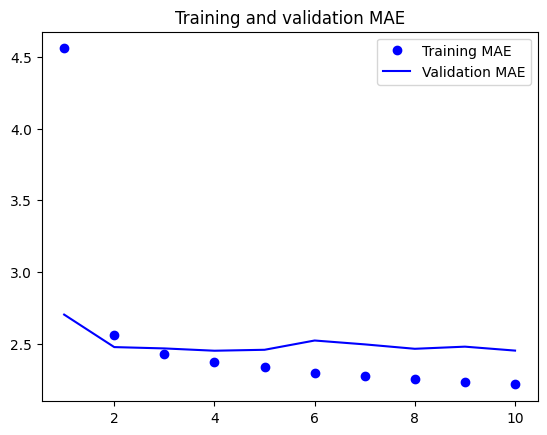

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**A basic LSTM model with a Dense layer of 32 units**

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 40.5889 - mae: 4.6258 - val_loss: 9.7952 - val_mae: 2.4242
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 9.3311 - mae: 2.3711 - val_loss: 10.1763 - val_mae: 2.4395
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 49ms/step - loss: 8.3752 - mae: 2.2448 - val_loss: 10.0915 - val_mae: 2.4587
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 7.7273 - mae: 2.1586 - val_loss: 10.7885 - val_mae: 2.5547
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 7.1159 - mae: 2.0715 - val_loss: 10.5355 - val_mae: 2.5344
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 6.6299 - mae: 1.9972 - val_loss: 11.0110 - val_mae: 2.5923
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 6.2833 - mae: 1.9417 - val_loss: 11.4857 - val_mae: 2.6542
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 5.9353 - mae: 1.8878 - val_loss: 11.9657 - val_mae: 2.6984
Epoch 9/10
819/819 ━━━━━━━━━━━━━

**Plotting results**

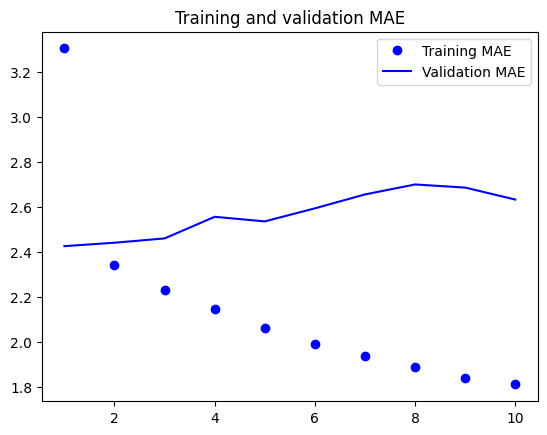

In [22]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**A basic LSTM model with a Dense layer of 64 units**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - loss: 27.0041 - mae: 3.7005 - val_loss: 9.6315 - val_mae: 2.3991
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - loss: 8.0686 - mae: 2.2126 - val_loss: 10.3596 - val_mae: 2.5112
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 6.5738 - mae: 1.9856 - val_loss: 11.5855 - val_mae: 2.6709
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 5.5322 - mae: 1.8149 - val_loss: 11.5715 - val_mae: 2.6319
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - loss: 4.7553 - mae: 1.6757 - val_loss: 12.2494 - val_mae: 2.7329
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - loss: 4.2621 - mae: 1.5827 - val_loss: 12.3016 - val_mae: 2.7413
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - loss: 3.7988 - mae: 1.4898 - val_loss: 12.8917 - val_mae: 2.7792
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 3.4056 - mae: 1.4078 - val_loss: 12.9636 - val_mae: 2.8197
Epoch 9/10
819/819 ━━━━━━━━━━━━━

**Plotting results**

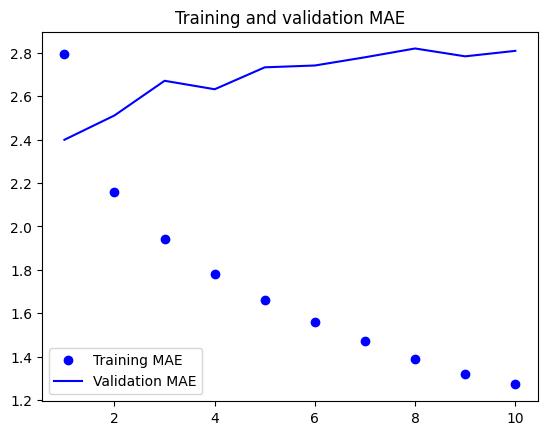

In [24]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Comprehending recurrent neural networks**

**NumPy implementation of a simple RNN**

In [25]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

**A recurrent layer within Keras**

**An RNN layer capable of handling sequences of varying lengths**

In [26]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that provides only its final output step**

In [27]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that provides its full output sequence**

In [28]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [29]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

**Advanced applications of recurrent neural networks**

**Applying recurrent dropout to combat overfitting**

**Training and evaluating a combination of 1d_Convnet and dropout-regularized LSTM**

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(32, 5, activation="relu", padding="same")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(64, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 133s 158ms/step - loss: 25.7851 - mae: 3.7409 - val_loss: 9.2660 - val_mae: 2.3623
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 130s 158ms/step - loss: 11.9383 - mae: 2.6976 - val_loss: 9.2851 - val_mae: 2.3663
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 159ms/step - loss: 10.9136 - mae: 2.5705 - val_loss: 9.4922 - val_mae: 2.3825
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 159ms/step - loss: 10.2811 - mae: 2.4918 - val_loss: 9.6930 - val_mae: 2.4255
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 130s 158ms/step - loss: 9.7509 - mae: 2.4228 - val_loss: 9.5424 - val_mae: 2.4063
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 158ms/step - loss: 9.1983 - mae: 2.3470 - val_loss: 9.6919 - val_mae: 2.4196
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 130s 159ms/step - loss: 8.7857 - mae: 2.2951 - val_loss: 9.5571 - val_mae: 2.4054
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 131s 159ms/step - loss: 8.4127 - mae: 2.2386 - val_loss: 10.2759 - val_mae: 2.5182
Epoch 9/10
819/819 

**Plotting results**

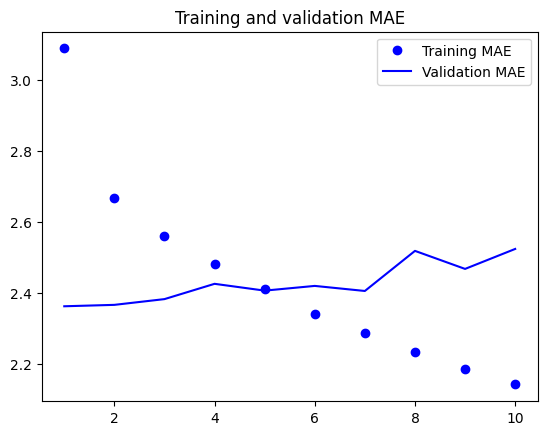

In [31]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [32]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

**Stacking multiple recurrent layers**

**Training and assessing a dropout-regularized, stacked LSTM model***

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 405s 491ms/step - loss: 44.0047 - mae: 4.9342 - val_loss: 9.9304 - val_mae: 2.4439
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 406s 447ms/step - loss: 14.7786 - mae: 2.9878 - val_loss: 9.0088 - val_mae: 2.3217
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 370s 452ms/step - loss: 13.7144 - mae: 2.8781 - val_loss: 8.8399 - val_mae: 2.2988
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 383s 453ms/step - loss: 12.9099 - mae: 2.7857 - val_loss: 8.7862 - val_mae: 2.2931
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 376s 446ms/step - loss: 12.2558 - mae: 2.7161 - val_loss: 8.6202 - val_mae: 2.2678
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 382s 446ms/step - loss: 11.6733 - mae: 2.6539 - val_loss: 8.6642 - val_mae: 2.2862
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 366s 447ms/step - loss: 11.2583 - mae: 2.6089 - val_loss: 8.9751 - val_mae: 2.3275
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 384s 449ms/step - loss: 10.8547 - mae: 2.5615 - val_loss: 8.8780 - val_mae: 2.3109
Epoch 9/10
819/8

**Plotting results**

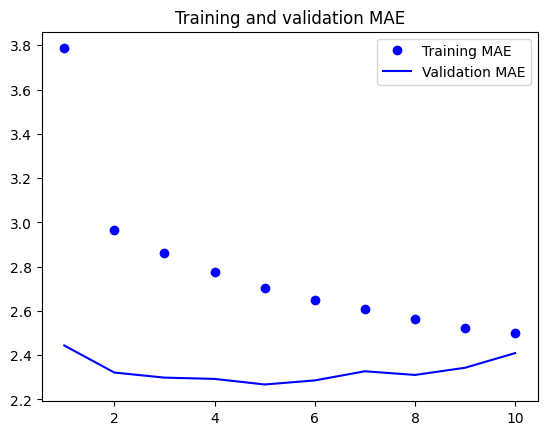

In [34]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Employing bidirectional RNNs**

**Training and evaluating a bidirectional LSTM**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16,recurrent_dropout=0.25))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 310s 375ms/step - loss: 53.1615 - mae: 5.4122 - val_loss: 10.2005 - val_mae: 2.4772
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 307s 374ms/step - loss: 10.4897 - mae: 2.5351 - val_loss: 9.4125 - val_mae: 2.3800
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 307s 375ms/step - loss: 9.4283 - mae: 2.3947 - val_loss: 9.2543 - val_mae: 2.3475
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 309s 377ms/step - loss: 8.9479 - mae: 2.3375 - val_loss: 9.1051 - val_mae: 2.3200
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 320s 374ms/step - loss: 8.6205 - mae: 2.2974 - val_loss: 9.2997 - val_mae: 2.3373
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 310s 379ms/step - loss: 8.3430 - mae: 2.2597 - val_loss: 9.5447 - val_mae: 2.3627
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 318s 389ms/step - loss: 8.1382 - mae: 2.2303 - val_loss: 9.5389 - val_mae: 2.3593
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 327s 394ms/step - loss: 7.9265 - mae: 2.2006 - val_loss: 9.7423 - val_mae: 2.3850
Epoch 9/10
819/819 ━━

**Plotting results**

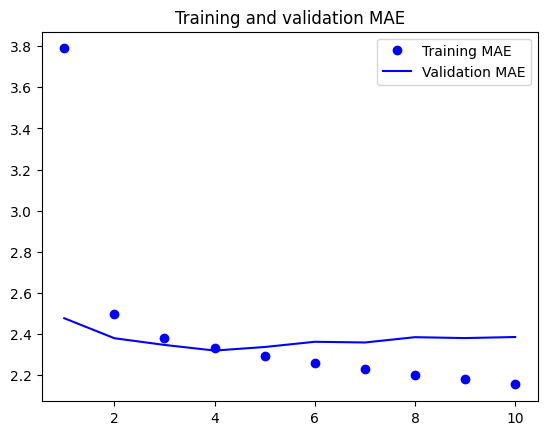

In [36]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()